# **PI² Research & Exploration | Stochastic Volatility Models**

Volatility is not constant in real markets. In this notebook, we study the Heston and SABR models that capture accurate behavior of volatility, and allow better option pricing and volatility surface fitting.

## **An Overview of Volatility Modelling in Finance**

Volatility is one of the most fundamental and studied concepts in quantitative finance. It measures the degree of variation or uncertainty in the price of a financial asset over time, reflecting how much returns deviate from their average value. In practical terms, high volatility implies larger and more unpredictable price swings, often associated with greater risk and potential reward for investors.

Classic financial models like Black–Scholes assume constant volatility, a simplification that makes analytic pricing possible but fails to capture real market behavior. Actual market volatility is time-varying, persistent, and exhibits asymmetric behavior: volatility tends to rise more after negative shocks than after positive ones.

Since the 1970s, multiple generations of volatility models have been developed to address these limitations. Statistical approaches, such as ARCH and GARCH models (Engle, R.), introduce conditional heteroskedasticity to describe volatility’s dynamics, while more advanced frameworks like stochastic volatility models treat volatility itself as a random process evolving according to its own SDE.

These developments have significantly improved the realism and predictive power of financial models. Stochastic volatility frameworks like the Heston and SABR models allow volatility to vary randomly over time and capture phenomena such as mean reversion, volatility smiles, and correlations between asset returns and variance.

## **Motivations for Stochastic Volatilty**

In the Black-Scholes model, the asset price is the only stochastic process, following a geometric brownian motion (GBM):

$$dS_t = \mu \cdot S_t \cdot dt + \sigma \cdot S_t \cdot dW^P_t$$

The log return follows a gaussian distribution:
$$\left\{
\begin{aligned}
S_T &= S_0 \cdot e^{\left(\mu - \frac{\sigma^2}{2}\right) \cdot T + \sigma \cdot W_T} \\
\ln\!\left(\frac{S_T}{S_0}\right) &\sim \mathcal{N}\!\left(\left(\mu - \frac{\sigma^2}{2}\right) \cdot T,\, \sigma^2 \cdot T\right)
\end{aligned}
\right.$$

But in practice, historical returns have fatter tails.

For instance, let's take a look at the daily returns of the S&P500:

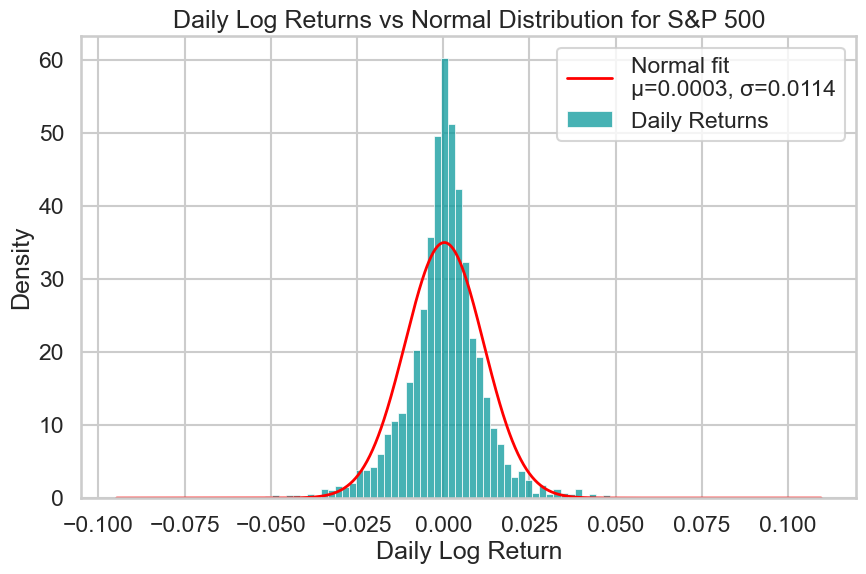

In [8]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# daily data from 1986 to 2018 (from Kaggle)
sp500 = pd.read_csv("spx.csv")
sp500["Return"] = np.log(sp500["close"] / sp500["close"].shift(1))
mu, sigma = sp500["Return"].mean(), sp500["Return"].std()
sp500["date"] = pd.to_datetime(sp500["date"], format="%d-%b-%y")
sp500 = sp500[(sp500["date"] >= "2000-01-01") & (sp500["date"] <= "2018-12-31")]
# Plot histogram
plt.figure(figsize=(10,6))
sns.histplot(sp500["Return"], bins=100, kde=False, color="#09999B", stat='density', label='Daily Returns')

# Plot normal distribution
x = np.linspace(sp500["Return"].min(), sp500["Return"].max(), 1000)
plt.plot(x, norm.pdf(x, mu, sigma), 'r', lw=2, label=f'Normal fit\nμ={mu:.4f}, σ={sigma:.4f}')

plt.title(f'Daily Log Returns vs Normal Distribution for S&P 500')
plt.xlabel('Daily Log Return')
plt.ylabel('Density')
plt.legend()
plt.show()

As we can see, returns are not exactly normal.

Let's plot the daily log returns over time:

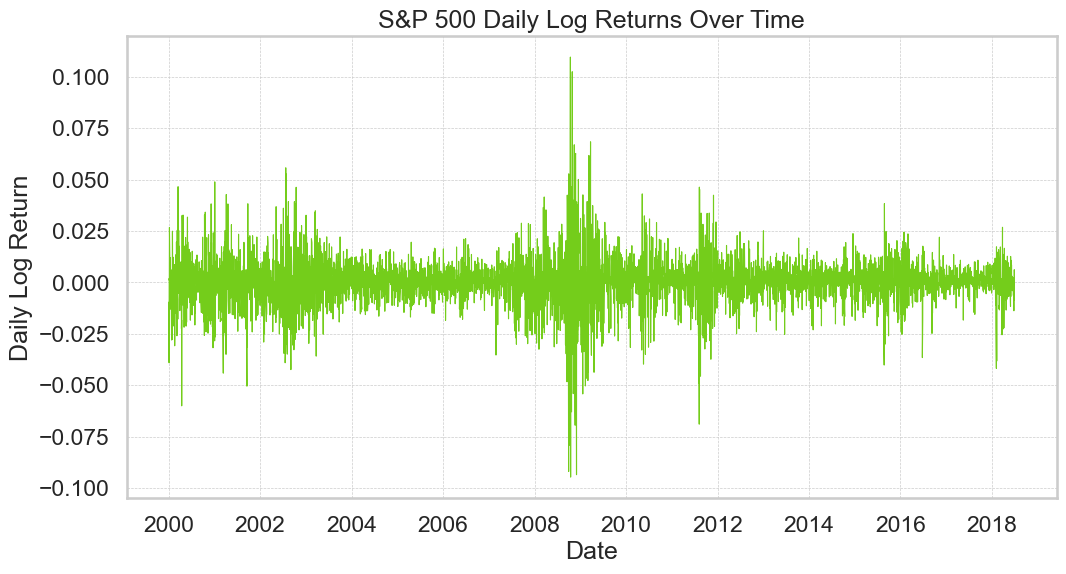

In [9]:
# Let's plot daily returns of the S&P
plt.figure(figsize=(12,6))
plt.plot(sp500["date"], sp500["Return"], color="#74CD1B", linewidth=0.8)
plt.title("S&P 500 Daily Log Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Daily Log Return")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

We can look at the VIX index, that measures the market's expectation of volatility on the S&P500 over the next 30 days.

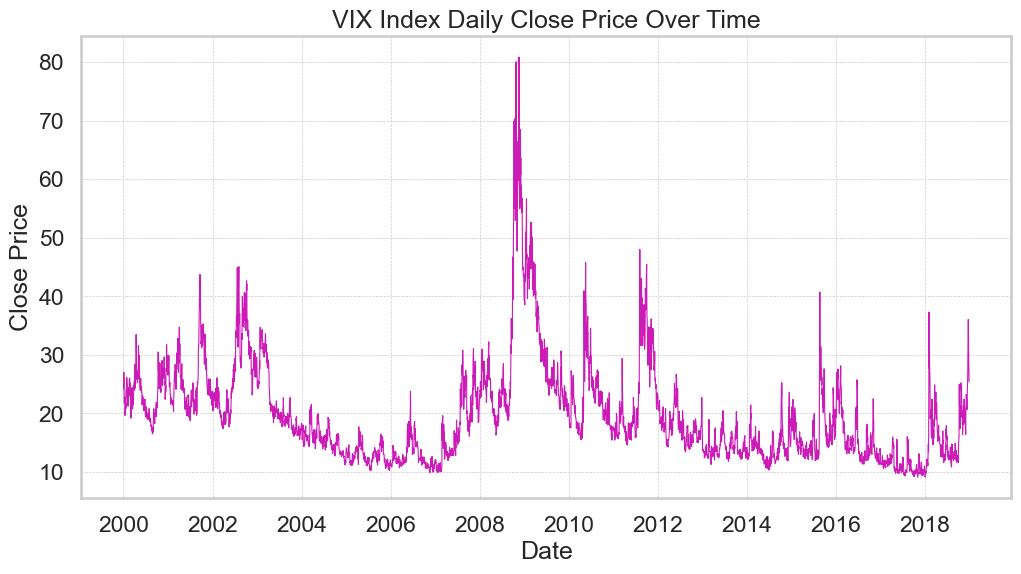

In [10]:
# Let's plot the VIX index
vix = pd.read_csv("vix_daily.csv")
vix["date"] = pd.to_datetime(vix["date"])
vix = vix[(vix["date"] >= "2000-01-01") & (vix["date"] <= "2018-12-31")]
vix.rename(columns={"close": "close_vix"}, inplace=True)
plt.figure(figsize=(12,6))
plt.plot(vix["date"], vix["close_vix"], color="#CD1BB8", linewidth=0.8)
plt.title("VIX Index Daily Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

We can see that actual volatility changes with time, and we tend to observe higher volatilities in periods of market stress, when stock returns are more negative. Here we plot the S&P returns vs the daily change of the VIX index to show this correlation:

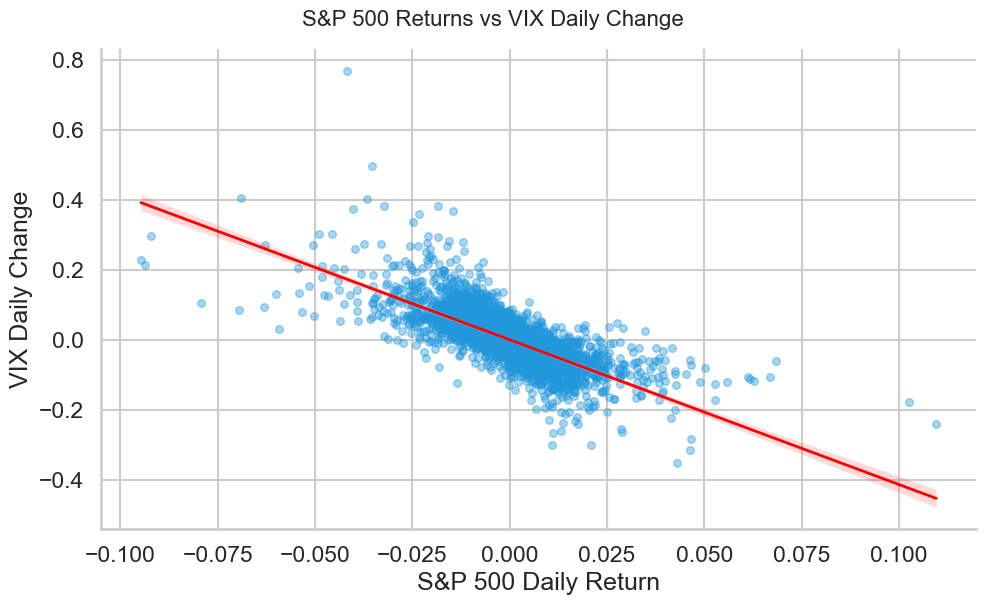

In [ ]:
sns.set_style("whitegrid")
sns.set_context("talk")
merged_index = pd.merge(sp500, vix, on="date", how="inner")
merged_index["Return_vix"] = np.log(merged_index["close_vix"] / merged_index["close_vix"].shift(1))
g = sns.lmplot(
    x="Return",
    y="Return_vix",
    data=merged_index,
    line_kws={"color": "red", "lw": 2},
    scatter_kws={"alpha": 0.4, "s": 30, "color": "#2197DC"},
    height=6,
    aspect=1.7
)

g.figure.suptitle("S&P 500 Returns vs VIX Daily Change", fontsize=16, y=1.02)
g.set_axis_labels("S&P 500 Daily Return", "VIX Daily Change")

plt.show()

Stochastic volatility models try to represent more accurately the volatility behavior we defined, and can perform very well in different market scenarios.

## **The Heston Model**

The Heston model, developed in 1993 by Heston, Steven L. assumes that volatility follows a mean-reverting square-root process (CIR process). It captures volatility clustering and smiles observed in real markets.

Volatility and asset price are assumed to be correlated.

The Heston model satisfies the following relations:
$$\begin{cases}
dS_t = \mu S_t\,dt + \sqrt{\nu_t}\,S_t\,dW_t^{(1)}, \\[6pt]
d\nu_t = \kappa(\theta - \nu_t)\,dt + \eta\sqrt{\nu_t}\,dW_t^{(2)}, \\[6pt]
dW_t^{(1)}\,dW_t^{(2)} = \rho\,dt.
\end{cases}$$

With:

- $S_t$: underlying price
- $\nu_t$: instantaneous variance $=(\sigma(t))^2$
- $\mu$: drift
- $\kappa$: mean reversion speed
- $\theta$: long-term variance
- $\eta$: volatility of volatility (vol of vol)
- $\rho$: correlation between $W^{(1)}$ and $W^{(2)}$

Here, $dS_t$ is a standard geometric Brownian motion but the volatility $\nu_t$ is itself a stochastic process (defined above).

#### **Discretization of the GBM**

To compute a GBM, which is a continuous process, we need to discretize it.

##### **Euler-Maruyama method**

We can write the general integral form of a GBM as:

$$Y(t_{n+1}) - Y(t_n) = \mu \int_{t_n}^{t_{n+1}} Y(s)\, ds + \sigma \int_{t_n}^{t_{n+1}} Y(s)\, dW_t(s)$$

The Euler-Maruyama method is a stochastic generalization of the Euler method from ODEs that we are familiar with. It approximates the GBM as:

$$X_{n+1}-X_n=\mu X_n \Delta t_n+\sigma X_n \Delta W_n$$

In our case of the Heston model, the variance process $\nu_t$ is approximated by:
$$\nu_{t_{n+1}}= \nu_{t_n}+ \kappa (\theta - \nu{t_n})\Delta t + \sigma \sqrt{\nu_{t_n}}\Delta W_2$$

And the stock price process $S_t$ is approximated by:
$$S_{t_{n+1}}=S_{t_n}(1 + \mu \Delta t + \sqrt{\nu_{t_n}}\Delta W_1)$$

##### **Milstein method**

The Milstein method improves the accuracy of the Euler-Maruyama approximation by adding a correction term derived from the stochastic Taylor series expansion of $Y(t)$ by applying Itô's lemma to the brownian motion functions. The following differential form appears:

$$X_{n+1} - X_n = a(X_n)\,\Delta t + b(X_n)\,\Delta B_n + 0.5\,\sigma^2 X_n \big((\Delta B_n)^2 - \Delta t\big)$$

In our case for the variance process $\nu_t$:
- $a(X_n)=\kappa (\theta-\nu_t)$
- $b(X_n)=\sigma \sqrt{\nu_t}$

And for the stock price $S_t$:
- $a(X_t)=\mu S_t$
- $b(X_t)= \sqrt{\nu_t}S_t$

### **Python implementation**

Simulating Heston model...

SIMULATION STATISTICS
Mean terminal stock price: $105.14
Std terminal stock price:  $19.50
Mean terminal variance:    0.0415
Std terminal variance:     0.0576

Generating visualizations...


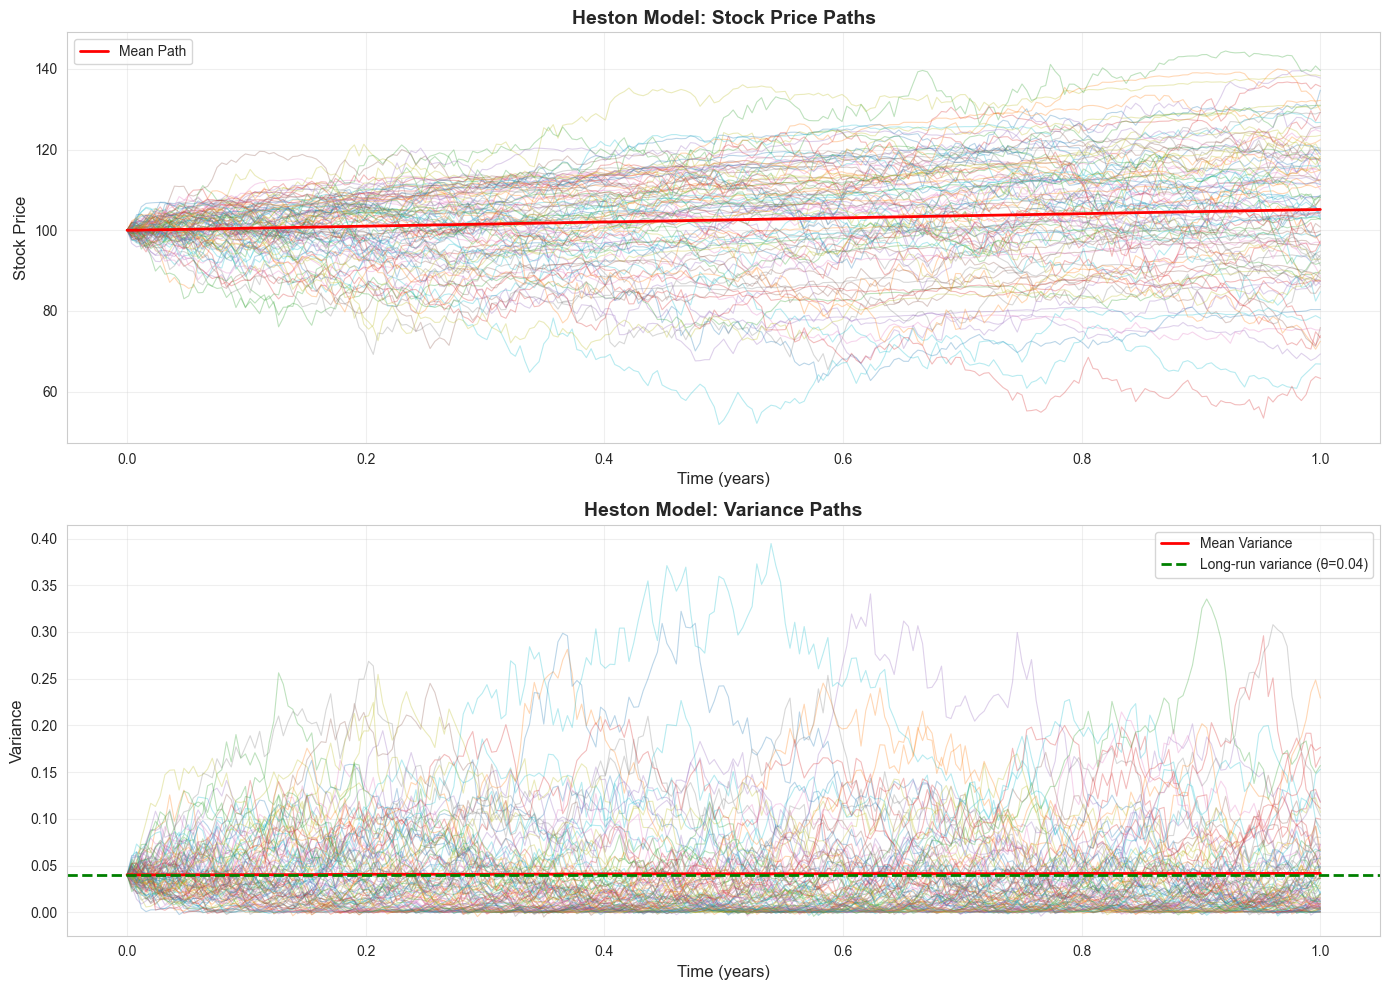

C:\Users\Adrien\AppData\Local\Temp\ipykernel_13220\2268728945.py:160: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  plt.tight_layout()
c:\Users\Adrien\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


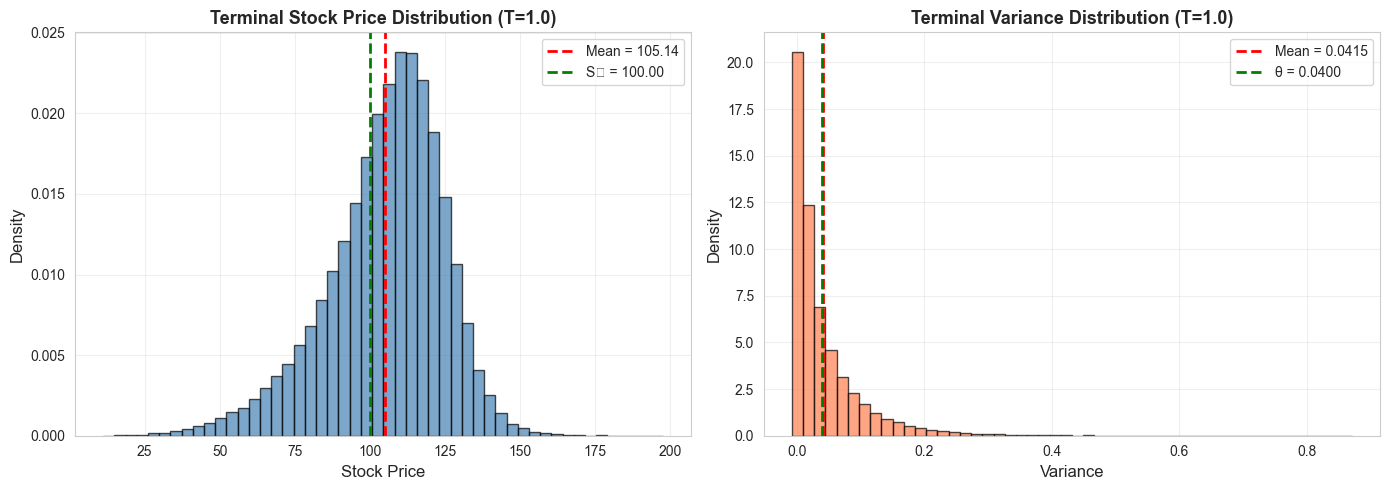

C:\Users\Adrien\AppData\Local\Temp\ipykernel_13220\2268728945.py:234: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  plt.tight_layout()



Calculating implied volatilities for 25 strikes...
  Strike 73.33 (K/S=0.73): IV=26.23%
  Strike 90.00 (K/S=0.90): IV=21.77%
  Strike 106.67 (K/S=1.07): IV=17.75%
  Strike 123.33 (K/S=1.23): IV=14.82%
  Strike 140.00 (K/S=1.40): IV=nan%

Smile characteristics:
  ATM vol: 19.28%
  Min vol: 14.82%
  Max vol: 30.19%
  Vol skew: 15.37%


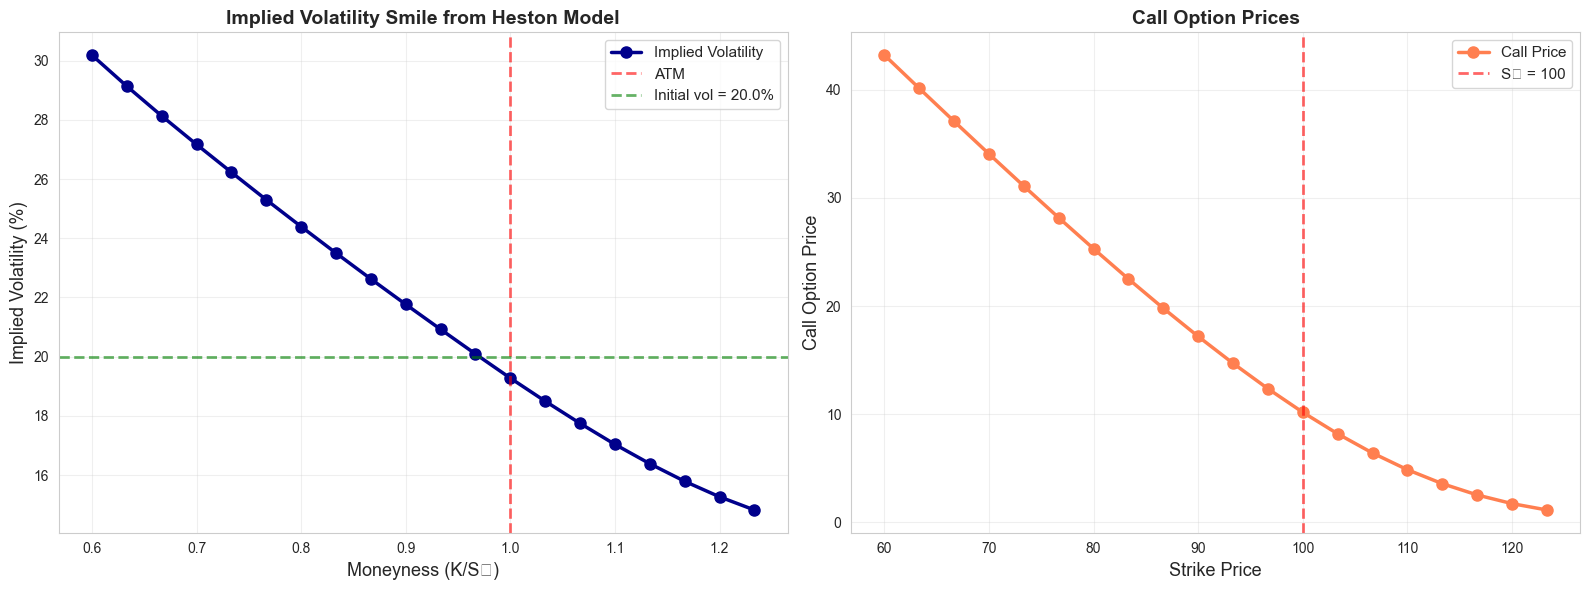

In [ ]:
# Import librairies independently from the other cells
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Heston Model Implementation
class HestonModel:    
    # Model parameters
    def __init__(self, S0, v0, mu, kappa, theta, sigma, rho, T, n_steps, n_paths):
        self.S0 = S0 # Initial stock price
        self.v0 = v0 # Initial variance
        self.mu = mu # Average return on the stock (drift)
        self.kappa = kappa # Speed of mean reversion
        self.theta = theta # Long run average variance
        self.sigma = sigma # Volatility of volatility
        self.rho = rho # Correlation between the brownian motions
        self.T = T # Time horizon (years)
        self.n_steps = n_steps # Number of steps in the simulation
        self.n_paths = n_paths # Number of Monte Carlo paths
        self.dt = T / n_steps # Size of each time step
        
        # Storage variables
        self.Stock_otime = None
        self.var_otime = None
        self.time_grid = None
    
    # Path simulations using different discretization schemes
    def simulate(self, scheme='euler'):
        """
        Simulate paths using specified discretization scheme
        
        Parameters:
        -----------
        scheme : str
            'euler' for Euler discretization
            'milstein' for Milstein scheme
        """
        # Initialize arrays
        self.Stock_otime = np.zeros((self.n_paths, self.n_steps + 1))
        self.var_otime = np.zeros((self.n_paths, self.n_steps + 1))
        self.time_grid = np.linspace(0, self.T, self.n_steps + 1)
        
        # Set initial conditions
        self.Stock_otime[:, 0] = self.S0
        self.var_otime[:, 0] = self.v0
        
        # Generate correlated Brownian motions
        for i in range(self.n_steps):
            # Generate independent standard normals
            Z1 = np.random.standard_normal(self.n_paths)
            Z2 = np.random.standard_normal(self.n_paths)
            
            # Create correlated Brownian increments
            dW1 = np.sqrt(self.dt) * Z1
            dW2 = np.sqrt(self.dt) * (self.rho * Z1 + np.sqrt(1 - self.rho**2) * Z2)
            
            # The Feller condition ensures that 0 < var
            # Makes sure negative values are managed
            v_current = np.maximum(self.var_otime[:, i], 0)
            
            if scheme == 'euler':
                # Euler scheme for variance
                self.var_otime[:, i + 1] = (v_current + self.kappa * (self.theta - v_current) * self.dt + self.sigma * np.sqrt(v_current) * dW2)
                
                # Euler scheme for stock price
                self.Stock_otime[:, i+1] = self.Stock_otime[:, i] * np.exp((self.mu - 0.5*v_current)*self.dt + np.sqrt(v_current)*dW1)

                
            elif scheme == 'milstein':
                # Milstein scheme for variance
                self.var_otime[:, i + 1] = (v_current + 
                                   self.kappa * (self.theta - v_current) * self.dt + 
                                   self.sigma * np.sqrt(v_current) * dW2 +
                                   0.25 * self.sigma**2 * (dW2**2 - self.dt))
                
                # Stock price
                self.Stock_otime[:, i + 1] = (self.Stock_otime[:, i] * 
                                   (1 + self.mu * self.dt + np.sqrt(v_current) * dW1))
        
        return self.Stock_otime, self.var_otime, self.time_grid
    
    def get_statistics(self):
        """Calculate statistics from simulated paths"""
        if self.Stock_otime is None:
            raise ValueError("Run simulate() first")
        
        stats = {
            'mean_price': np.mean(self.Stock_otime[:, -1]),
            'std_price': np.std(self.Stock_otime[:, -1]),
            'mean_variance': np.mean(self.var_otime[:, -1]),
            'std_variance': np.std(self.var_otime[:, -1]),
            'final_prices': self.Stock_otime[:, -1],
            'final_variances': self.var_otime[:, -1]
        }
        return stats


def plot_sample_paths(heston, n_display=100):
    """Plot sample paths for stock price and variance"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot stock price paths
    for i in range(min(n_display, heston.n_paths)):
        ax1.plot(heston.time_grid, heston.Stock_otime[i, :], alpha=0.3, linewidth=0.8)
    ax1.plot(heston.time_grid, np.mean(heston.Stock_otime, axis=0), 'r-', linewidth=2, label='Mean Path')
    ax1.set_xlabel('Time (years)', fontsize=12)
    ax1.set_ylabel('Stock Price', fontsize=12)
    ax1.set_title('Heston Model: Stock Price Paths', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot variance paths
    for i in range(min(n_display, heston.n_paths)):
        ax2.plot(heston.time_grid, heston.var_otime[i, :], alpha=0.3, linewidth=0.8)
    ax2.plot(heston.time_grid, np.mean(heston.var_otime, axis=0), 'r-', linewidth=2, label='Mean Variance')
    ax2.axhline(y=heston.theta, color='g', linestyle='--', linewidth=2, label=f'Long-run variance (θ={heston.theta})')
    ax2.set_xlabel('Time (years)', fontsize=12)
    ax2.set_ylabel('Variance', fontsize=12)
    ax2.set_title('Heston Model: Variance Paths', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


def plot_terminal_distributions(heston):
    """Plot terminal distributions of price and variance"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    stats = heston.get_statistics()
    
    # Terminal stock price distribution
    axes[0].hist(stats['final_prices'], bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0].axvline(stats['mean_price'], color='r', linestyle='--', linewidth=2, label=f"Mean = {stats['mean_price']:.2f}")
    axes[0].axvline(heston.S0, color='g', linestyle='--', linewidth=2, label=f"S₀ = {heston.S0:.2f}")
    axes[0].set_xlabel('Stock Price', fontsize=12)
    axes[0].set_ylabel('Density', fontsize=12)
    axes[0].set_title(f'Terminal Stock Price Distribution (T={heston.T})', fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Terminal variance distribution
    axes[1].hist(stats['final_variances'], bins=50, density=True, alpha=0.7, color='coral', edgecolor='black')
    axes[1].axvline(stats['mean_variance'], color='r', linestyle='--', linewidth=2, label=f"Mean = {stats['mean_variance']:.4f}")
    axes[1].axvline(heston.theta, color='g', linestyle='--', linewidth=2, label=f"θ = {heston.theta:.4f}")
    axes[1].set_xlabel('Variance', fontsize=12)
    axes[1].set_ylabel('Density', fontsize=12)
    axes[1].set_title(f'Terminal Variance Distribution (T={heston.T})', fontsize=13, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


def plot_volatility_smile(heston, r=0.05, strikes=None, n_strikes=25):
    """
    Approximate implied volatility smile using Monte Carlo prices
    
    Parameters:
    -----------
    heston : HestonModel
        Simulated Heston model
    r : float
        Risk-free rate
    strikes : array-like
        Strike prices for options
    n_strikes : int
        Number of strikes to use if strikes is None
    """
    if strikes is None:
        # Create strikes from 60% to 140% of spot
        strikes = np.linspace(0.6 * heston.S0, 1.4 * heston.S0, n_strikes)
    
    # Calculate option prices and implied vols
    S_T = heston.Stock_otime[:, -1]
    call_prices = []
    impl_vols = []
    
    print(f"\nCalculating implied volatilities for {len(strikes)} strikes...")
    
    for i, K in enumerate(strikes):
        # Monte Carlo call option price
        payoff = np.maximum(S_T - K, 0)
        call_price = np.exp(-r * heston.T) * np.mean(payoff)
        call_prices.append(call_price)
        
        # Calculate implied volatility
        try:
            impl_vol = implied_volatility_newton(call_price, heston.S0, K, heston.T, r)
            impl_vols.append(impl_vol)
            if (i+1) % 5 == 0:
                print(f"  Strike {K:.2f} (K/S={K/heston.S0:.2f}): IV={impl_vol:.2%}")
        except:
            impl_vols.append(np.nan)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    moneyness = strikes / heston.S0
    impl_vols_array = np.array(impl_vols)
    valid_idx = ~np.isnan(impl_vols_array)
    
    # Plot 1: IV vs Moneyness
    ax1.plot(moneyness[valid_idx], impl_vols_array[valid_idx] * 100, 
             'o-', linewidth=2.5, markersize=8, color='darkblue', label='Implied Volatility')
    ax1.axvline(x=1.0, color='red', linestyle='--', alpha=0.6, linewidth=2, label='ATM')
    ax1.axhline(y=np.sqrt(heston.v0)*100, color='green', linestyle='--', 
                alpha=0.6, linewidth=2, label=f'Initial vol = {np.sqrt(heston.v0)*100:.1f}%')
    ax1.set_xlabel('Moneyness (K/S₀)', fontsize=13)
    ax1.set_ylabel('Implied Volatility (%)', fontsize=13)
    ax1.set_title('Implied Volatility Smile from Heston Model', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=11)
    
    # Plot 2: Call prices vs Strike
    ax2.plot(strikes[valid_idx], np.array(call_prices)[valid_idx], 
             'o-', linewidth=2.5, markersize=8, color='coral', label='Call Price')
    ax2.axvline(x=heston.S0, color='red', linestyle='--', alpha=0.6, linewidth=2, label=f'S₀ = {heston.S0}')
    ax2.set_xlabel('Strike Price', fontsize=13)
    ax2.set_ylabel('Call Option Price', fontsize=13)
    ax2.set_title('Call Option Prices', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=11)
    
    plt.tight_layout()
    
    print(f"\nSmile characteristics:")
    print(f"  ATM vol: {impl_vols_array[valid_idx][np.argmin(np.abs(moneyness[valid_idx] - 1.0))]:.2%}")
    print(f"  Min vol: {np.nanmin(impl_vols_array):.2%}")
    print(f"  Max vol: {np.nanmax(impl_vols_array):.2%}")
    print(f"  Vol skew: {(np.nanmax(impl_vols_array) - np.nanmin(impl_vols_array)):.2%}")
    
    return fig, call_prices, impl_vols


def black_scholes_call(S0, K, T, r, sigma):
    """Black-Scholes call option price"""
    if sigma <= 0 or T <= 0:
        return max(S0 - K, 0)
    
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def implied_volatility_newton(call_price, S0, K, T, r, tol=1e-6, max_iter=100):
    """
    Calculate implied volatility using Newton-Raphson method
    More robust than the simple approximation
    """
    # Check for arbitrage bounds
    intrinsic = max(S0 - K*np.exp(-r*T), 0)
    if call_price < intrinsic:
        return np.nan
    
    # Initial guess using Brenner-Subrahmanyam
    impl_vol = np.sqrt(2*np.pi/T) * (call_price/S0)
    impl_vol = max(0.01, min(impl_vol, 3.0))  # Bound initial guess
    
    for i in range(max_iter):
        d1 = (np.log(S0/K) + (r + 0.5*impl_vol**2)*T) / (impl_vol*np.sqrt(T))
        
        # Calculate price and vega
        bs_price = black_scholes_call(S0, K, T, r, impl_vol)
        vega = S0 * norm.pdf(d1) * np.sqrt(T)
        
        # Check convergence
        price_diff = bs_price - call_price
        if abs(price_diff) < tol:
            return impl_vol
        
        # Avoid division by very small vega
        if vega < 1e-10:
            return np.nan
        
        # Newton-Raphson update
        impl_vol_new = impl_vol - price_diff / vega
        
        # Ensure volatility stays positive and reasonable
        if impl_vol_new <= 0 or impl_vol_new > 5.0:
            # Try bisection as fallback
            return implied_volatility_bisection(call_price, S0, K, T, r)
        
        impl_vol = impl_vol_new
    
    # If didn't converge, return NaN
    return np.nan


def implied_volatility_bisection(call_price, S0, K, T, r, tol=1e-6):
    """Fallback bisection method for implied volatility"""
    vol_low, vol_high = 0.001, 5.0
    
    for _ in range(100):
        vol_mid = (vol_low + vol_high) / 2
        price_mid = black_scholes_call(S0, K, T, r, vol_mid)
        
        if abs(price_mid - call_price) < tol:
            return vol_mid
        
        if price_mid < call_price:
            vol_low = vol_mid
        else:
            vol_high = vol_mid
    
    return vol_mid


if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Heston model parameters
    S0 = 100 # Initial stock price
    v0 = 0.04 # Initial variance (vol = 20%)
    mu = 0.05 # Drift
    kappa = 3.0 # Mean reversion speed
    theta = 0.04 # Long-run variance
    sigma = 0.7 # Volatility of volatility (increased for more pronounced smile)
    rho = -0.7 # Correlation (typically negative for equity)
    T = 1.0 # Time horizon (1 year)
    n_steps = 252 # Daily steps
    n_paths = 100000 # Number of paths (increased for better MC accuracy)
    
    # Create and simulate model
    print("Simulating Heston model...")
    heston = HestonModel(S0, v0, mu, kappa, theta, sigma, rho, T, n_steps, n_paths)
    heston.simulate(scheme='euler')
    
    # Display statistics
    stats = heston.get_statistics()
    print(f"\n{'='*35}")
    print("SIMULATION STATISTICS")
    print(f"{'='*35}")
    print(f"Mean terminal stock price: ${stats['mean_price']:.2f}")
    print(f"Std terminal stock price:  ${stats['std_price']:.2f}")
    print(f"Mean terminal variance:    {stats['mean_variance']:.4f}")
    print(f"Std terminal variance:     {stats['std_variance']:.4f}")
    print(f"{'='*35}\n")
    
    # Generate all plots
    print("Generating visualizations...")
    
    fig1 = plot_sample_paths(heston, n_display=100)
    plt.show()
    
    fig2 = plot_terminal_distributions(heston)
    plt.show()
    
    fig3, call_prices, impl_vols = plot_volatility_smile(heston, r=0.05)
    plt.show()

Here we see more of a volatility smirk than a smile.

## **Bibliography** 
- Ribeiro, M. (2018). *Volatility Models in Option Pricing*, Master’s thesis, Instituto Superior Técnico.
- Quant Next. *Introduction to Stochastic Volatility Models*, [Website](https://quant-next.com/introduction-to-stochastic-volatility-models/).
- Yadav, P. (2024). *The SABR Volatility Model: Unlocking Realistic Market Behavior in Quantitative Finance*, [LinkedIn](https://www.linkedin.com/pulse/sabr-volatility-model-unlocking-realistic-market-behavior-yadav-r3kkc/).
- Chang, H. (2024). *Stochastic volatility models and their applications to financial markets*, Xi'an Jiaotong-Liverpool University, [Publication](https://www.ewadirect.com/proceedings/aemps/article/view/18738).